In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

from __future__ import division
from __future__ import print_function

import os
import copy
import argparse
import fnmatch
import numpy as np

import scipy
from scipy.interpolate import interp1d

# Astropy
from astropy.io import fits
from astropy    import units as u
from astropy.stats import sigma_clip
# AstroML
from astroML.plotting import hist

# Matplotlib related
# Matplotlib default settings
rcdef = plt.rcParams.copy()
pylab.rcParams['figure.figsize'] = 12, 10
pylab.rcParams['xtick.major.size'] = 8.0
pylab.rcParams['xtick.major.width'] = 2.5
pylab.rcParams['xtick.minor.size'] = 4.0
pylab.rcParams['xtick.minor.width'] = 2.5
pylab.rcParams['ytick.major.size'] = 8.0
pylab.rcParams['ytick.major.width'] = 2.5
pylab.rcParams['ytick.minor.size'] = 4.0
pylab.rcParams['ytick.minor.width'] = 2.5
pylab.rcParams['legend.numpoints'] = 1

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.ticker import NullFormatter
from matplotlib.ticker import MaxNLocator

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [7]:
sed_model = 'a_fsps_miles_chab'
#sed_model = 'b_bc03_stelib_chab'

In [8]:
z1Fits = 'sed/hsc_sed_z1' + sed_model + '_match.fits'
z2Fits = 'sed/hsc_sed_z2' + sed_model + '_match.fits'
z3Fits = 'sed/hsc_sed_z3' + sed_model + '_match.fits'

In [9]:
z1 = fits.open(z1Fits)[1].data
z2 = fits.open(z2Fits)[1].data
z3 = fits.open(z3Fits)[1].data

In [10]:
z1.columns

ColDefs(
    name = 'ISEDFIT_ID'; format = 'J'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'Z'; format = 'E'
    name = 'MAGGIES'; format = '5E'
    name = 'IVARMAGGIES'; format = '5E'
    name = 'BESTMAGGIES'; format = '5E'
    name = 'CHUNKINDX'; format = 'I'
    name = 'MODELINDX'; format = 'I'
    name = 'DELAYED'; format = 'J'
    name = 'BURSTTYPE'; format = 'J'
    name = 'CHI2'; format = 'E'
    name = 'TOTALMASS'; format = 'E'
    name = 'TOTALMASS_ERR'; format = 'E'
    name = 'MSTAR'; format = 'E'
    name = 'AGE'; format = 'E'
    name = 'SFRAGE'; format = 'E'
    name = 'TAU'; format = 'E'
    name = 'ZMETAL'; format = 'E'
    name = 'AV'; format = 'E'
    name = 'MU'; format = 'E'
    name = 'OIIIHB'; format = 'E'
    name = 'NLYC'; format = 'E'
    name = 'SFR'; format = 'E'
    name = 'SFR100'; format = 'E'
    name = 'B100'; format = 'E'
    name = 'B1000'; format = 'E'
    name = 'EWOII'; format = 'E'
    name = 'EWOIIIHB'; format = 'E'
   

In [11]:
z1Use = z1[(np.isfinite(z1['MSTAR'])) & 
           (z1['MSTAR'] >= 5.0) & 
           (z1['MSTAR'] <= 13.0)]
print("# Number of useful stellar mass / total number of galaxies in z1: %5d / %5d" % (len(z1Use), len(z1)))

z2Use = z2[(np.isfinite(z2['MSTAR'])) & 
           (z2['MSTAR'] >= 5.0) & 
           (z2['MSTAR'] <= 13.0)]
print("# Number of useful stellar mass / total number of galaxies in z2: %5d / %5d" % (len(z2Use), len(z2)))

z3Use = z3[(np.isfinite(z3['MSTAR'])) & 
           (z3['MSTAR'] >= 5.0) & 
           (z3['MSTAR'] <= 13.0)]
print("# Number of useful stellar mass / total number of galaxies in z3: %5d / %5d" % (len(z3Use), len(z3)))

# Number of useful stellar mass / total number of galaxies in z1: 20030 / 20255
# Number of useful stellar mass / total number of galaxies in z2: 12869 / 12869
# Number of useful stellar mass / total number of galaxies in z3:  6417 /  6417


In [12]:
print("# Mean error for logMstar of z1: %5.3f" % np.nanmean(z1['MSTAR_ERR']))
print("# Mean error for logMstar of z2: %5.3f" % np.nanmean(z2['MSTAR_ERR']))
print("# Mean error for logMstar of z3: %5.3f" % np.nanmean(z3['MSTAR_ERR']))

# Mean error for logMstar of z1: 0.027
# Mean error for logMstar of z2: 0.033
# Mean error for logMstar of z3: 0.043


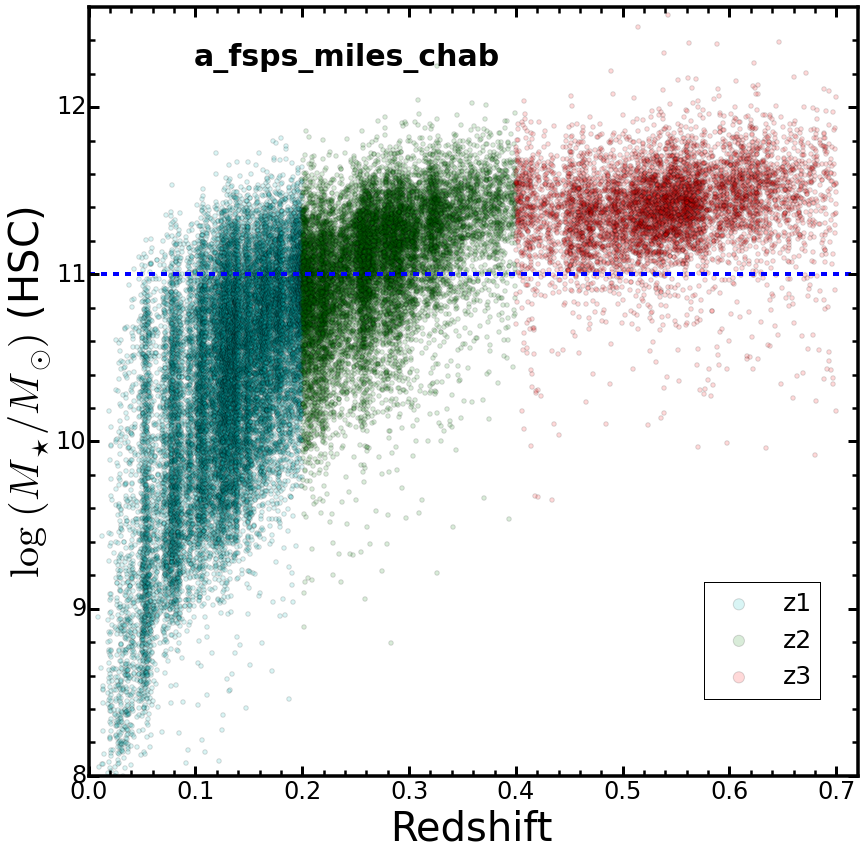

In [13]:
fig = plt.figure(figsize=(12, 12))
#fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
rec = [0.10, 0.10, 0.89, 0.89]
ax1 = plt.axes(rec)

# ---------------------------------------------------------------------------
# Scatter plot

# Matched ones 
ax1.scatter(z1['z_use'], z1['MSTAR'], s=20.0, 
            alpha=0.15, c='c', label='z1')

ax1.scatter(z2['z_use'], z2['MSTAR'], s=20.0, 
            alpha=0.15, c='g', label='z2')

ax1.scatter(z3['z_use'], z3['MSTAR'], s=20.0, 
            alpha=0.15, c='r', label='z3')

ax1.axhline(11.0, linewidth=4.0, linestyle='--')

# Axes setup
#  Minor Ticks on 
ax1.minorticks_on()
#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(3.5)
#  Tick Label Size 
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
#  Tick Length and Width
ax1.tick_params('both', length=10, width=3.0, which='major')
ax1.tick_params('both', length=6, width=2.5, which='minor')

# Label
ax1.set_xlabel('Redshift',  size=40)
ax1.set_ylabel('$\log\ (M_{\star}/M_{\odot})$ (HSC)', size=40)
# Axis limits
ax1.set_xlim(0.0, 0.72)
ax1.set_ylim(8.0, 12.6)

ax1.legend(fontsize=25.0, loc=(0.8, 0.10), numpoints=1, 
           scatterpoints=1, markerscale=2.5)

ax1.text(0.10, 12.25, sed_model, fontweight='bold', fontsize=30)

fig.savefig('hsc_gama_sed_mass_redshift.png', dpi=90)

# Compare Stellar Mass

In [14]:
# definitions for the axes
left, width    = 0.1, 0.71
right          = left + width 
bottom, height = 0.1, 0.88
bottom_h = left_h = left + width + 0.02
recScat = [left,   bottom, width, height]
recHist = [right,  bottom,  0.18, height]

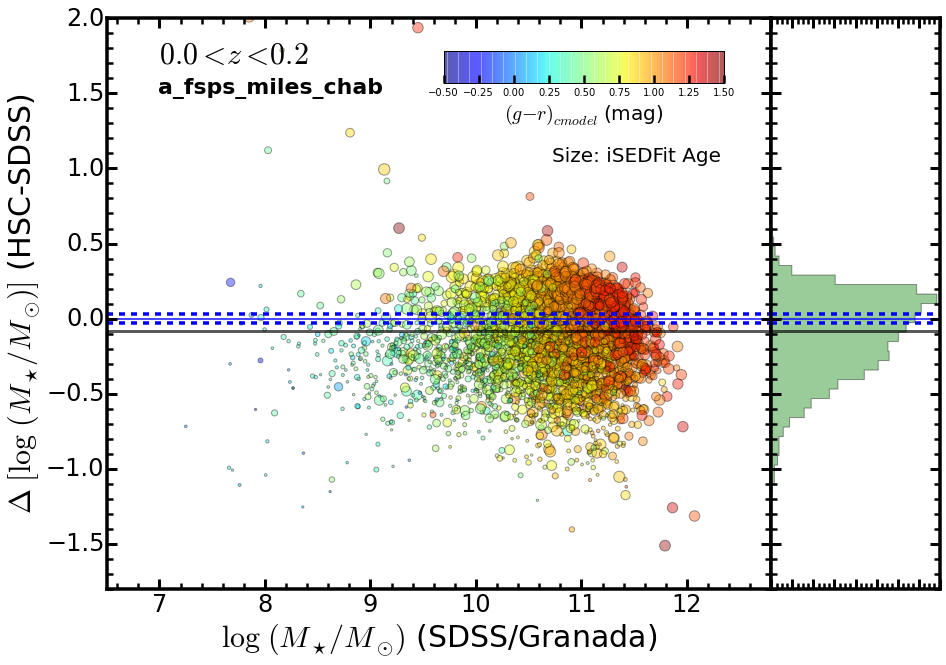

In [15]:
z1Color = z1['gmag_cmodel'] - z1['rmag_cmodel']
z1Age = z1['AGE']
z1MsHSC  = z1['MSTAR']
z1MsHSCErr = z1['MSTAR_ERR']
z1MsSDSS = z1['logms_gran']
z1MsGAMA = z1['logms_gama']

fig = plt.figure(figsize=(13, 9))
#fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = plt.axes(recScat)
ax2 = plt.axes(recHist)

# ---------------------------------------------------------------------------
# Scatter plot

# SDSS v.s. HSC
p = ax1.scatter(z1MsSDSS, (z1MsHSC - z1MsSDSS), 
                c=z1Color, s=z1Age * 10.0, alpha=0.4, 
                label='z1/SDSS', vmin=-0.5, vmax=1.5)

# Color bar 
cax = fig.add_axes([0.46, 0.88, 0.3, 0.05]) 
cb = plt.colorbar(p, orientation="horizontal", cax=cax)
cb.ax.set_xlabel(r'$(g-r)_{cmodel}$ (mag)', fontsize=20)

ax1.text(0.67, 0.75, 'Size: iSEDFit Age', fontsize=20, 
         transform = ax1.transAxes)

# Zero line
ax1.axhline(0.0, alpha=0.7, linewidth=2.0)

# Horizontal line 
ax1.axhline(np.nanmean(z1MsHSCErr), linestyle='dashed', linewidth=3.5)
ax1.axhline(-1.0 * np.nanmean(z1MsHSCErr), linestyle='dashed', 
            linewidth=3.5)

ax1.axhline(np.nanmedian((z1MsHSC - z1MsSDSS)), color='k',
            alpha=0.65, linewidth=3.0)

# Axes setup
#  Minor Ticks on 
ax1.minorticks_on()
#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(3.5)
#  Tick Label Size 
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
#  Tick Length and Width
ax1.tick_params('both', length=10, width=3.0, which='major')
ax1.tick_params('both', length=6, width=2.5, which='minor')

# Label
ax1.set_xlabel('$\log\ (M_{\star}/M_{\odot})$ (SDSS/Granada)',  size=30)
ax1.set_ylabel('$\Delta\ [\log\ (M_{\star}/M_{\odot})]$ (HSC-SDSS)', size=30)
# Axis limits
ax1.set_xlim(6.5, 12.8)
ax1.set_ylim(-1.8, 2.0)

ax1.text(7.0, 1.7, '$0.0 < z < 0.2$', fontsize=30)
ax1.text(7.0, 1.5, sed_model, fontsize=22, fontweight='bold')

# ---------------------------------------------------------------------------
# Histogram 
n, bins, patches=ax2.hist((z1MsHSC - z1MsSDSS), bins=60, range=[-1.8, 2.0], 
                             orientation='horizontal', histtype='stepfilled', 
                             color='g', alpha=0.4, normed=1)
#n, bins, patches=ax2.hist((yuse-xuse), bins=50, range=[-1.2, 4.2], 
#                             orientation='horizontal', histtype='step', 
#                             color='k', alpha=0.8, normed=1, linewidth=3.5)

ax2.set_ylim(ax1.get_ylim())

#ax2.legend(fontsize=15)

# Axes setup
#  Minor Ticks on 
ax2.minorticks_on()

#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax2.spines[axis].set_linewidth(3.5)
#  Tick Label Size 
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
#  Tick Length and Width
ax2.tick_params('both', length=10, width=3.0, which='major')
ax2.tick_params('both', length=6, width=2.5, which='minor')


ax2.axhline(0.0, alpha=0.7, linewidth=2.0)

# Horizontal line 
ax2.axhline(np.nanmean(z1MsHSCErr), linestyle='dashed', linewidth=3.5)
ax2.axhline(-1.0 * np.nanmean(z1MsHSCErr), linestyle='dashed', 
            linewidth=3.5)

ax2.axhline(np.nanmedian((z1MsHSC - z1MsSDSS)), color='k',
            alpha=0.65, linewidth=3.0)

ax2.yaxis.set_major_formatter(NullFormatter())
ax2.xaxis.set_major_formatter(NullFormatter())

#fig.savefig('hsc_gama_cmodelmag_i_1.png', dpi=90)

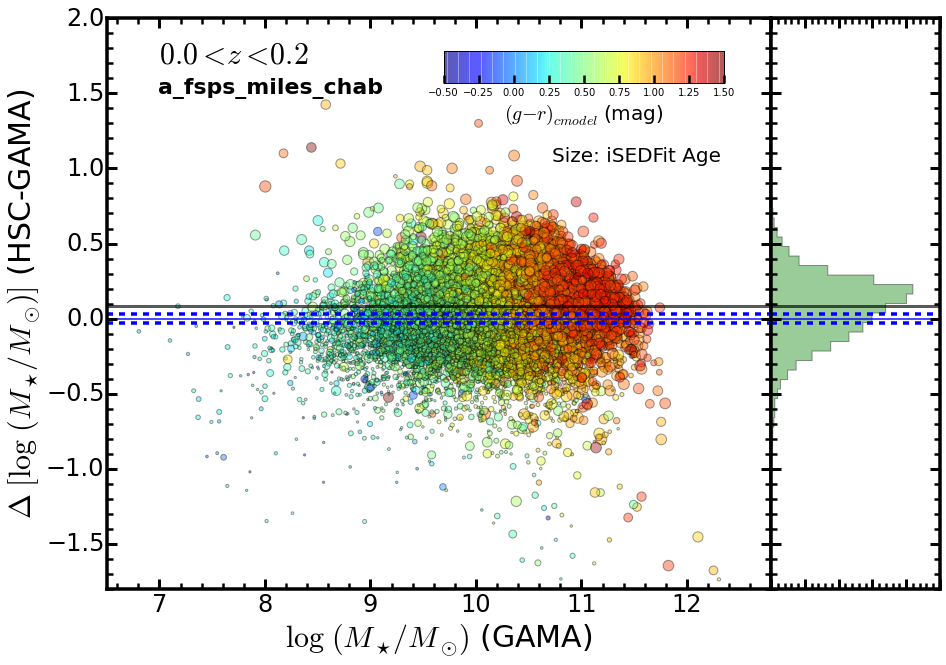

In [16]:
z1Color = z1['gmag_cmodel'] - z1['rmag_cmodel']
z1Age = z1['AGE']
z1MsHSC  = z1['MSTAR']
z1MsHSCErr = z1['MSTAR_ERR']
z1MsSDSS = z1['logms_gran']
z1MsGAMA = z1['logms_gama'] + np.log10(z1['fluxscale_gama'])

fig = plt.figure(figsize=(13, 9))
#fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = plt.axes(recScat)
ax2 = plt.axes(recHist)

# ---------------------------------------------------------------------------
# Scatter plot

# GAMA v.s. HSC
p = ax1.scatter(z1MsGAMA, (z1MsHSC - z1MsGAMA), 
                c=z1Color, s=z1Age * 10.0, alpha=0.4, 
                label='z1/GAMA', vmin=-0.5, vmax=1.5)

# Color bar 
cax = fig.add_axes([0.46, 0.88, 0.3, 0.05]) 
cb = plt.colorbar(p, orientation="horizontal", cax=cax)
cb.ax.set_xlabel(r'$(g-r)_{cmodel}$ (mag)', fontsize=20)

ax1.text(0.67, 0.75, 'Size: iSEDFit Age', fontsize=20, 
         transform = ax1.transAxes)

# Zero line
ax1.axhline(0.0, alpha=0.7, linewidth=2.0)

# Horizontal line 
ax1.axhline(np.nanmean(z1MsHSCErr), linestyle='dashed', linewidth=3.5)
ax1.axhline(-1.0 * np.nanmean(z1MsHSCErr), linestyle='dashed', 
            linewidth=3.5)

ax1.axhline(np.nanmedian((z1MsHSC - z1MsGAMA)), color='k',
            alpha=0.65, linewidth=3.0)

# Axes setup
#  Minor Ticks on 
ax1.minorticks_on()
#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(3.5)
#  Tick Label Size 
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
#  Tick Length and Width
ax1.tick_params('both', length=10, width=3.0, which='major')
ax1.tick_params('both', length=6, width=2.5, which='minor')

# Label
ax1.set_xlabel('$\log\ (M_{\star}/M_{\odot})$ (GAMA)',  size=30)
ax1.set_ylabel('$\Delta\ [\log\ (M_{\star}/M_{\odot})]$ (HSC-GAMA)', size=30)
# Axis limits
ax1.set_xlim(6.5, 12.8)
ax1.set_ylim(-1.8, 2.0)

ax1.text(7.0, 1.7, '$0.0 < z < 0.2$', fontsize=30)
ax1.text(7.0, 1.5, sed_model, fontsize=22, fontweight='bold')

# ---------------------------------------------------------------------------
# Histogram 
n, bins, patches=ax2.hist((z1MsHSC - z1MsGAMA), bins=60, range=[-1.8, 2.0], 
                             orientation='horizontal', histtype='stepfilled', 
                             color='g', alpha=0.4, normed=1)
#n, bins, patches=ax2.hist((yuse-xuse), bins=50, range=[-1.2, 4.2], 
#                             orientation='horizontal', histtype='step', 
#                             color='k', alpha=0.8, normed=1, linewidth=3.5)

ax2.set_ylim(ax1.get_ylim())

#ax2.legend(fontsize=15)

# Axes setup
#  Minor Ticks on 
ax2.minorticks_on()

#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax2.spines[axis].set_linewidth(3.5)
#  Tick Label Size 
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
#  Tick Length and Width
ax2.tick_params('both', length=10, width=3.0, which='major')
ax2.tick_params('both', length=6, width=2.5, which='minor')


ax2.axhline(0.0, alpha=0.7, linewidth=2.0)

# Horizontal line 
ax2.axhline(np.nanmean(z1MsHSCErr), linestyle='dashed', linewidth=3.5)
ax2.axhline(-1.0 * np.nanmean(z1MsHSCErr), linestyle='dashed', 
            linewidth=3.5)

ax2.axhline(np.nanmedian((z1MsHSC - z1MsGAMA)), color='k',
            alpha=0.65, linewidth=3.0)

ax2.yaxis.set_major_formatter(NullFormatter())
ax2.xaxis.set_major_formatter(NullFormatter())

#fig.savefig('hsc_gama_cmodelmag_i_1.png', dpi=90)

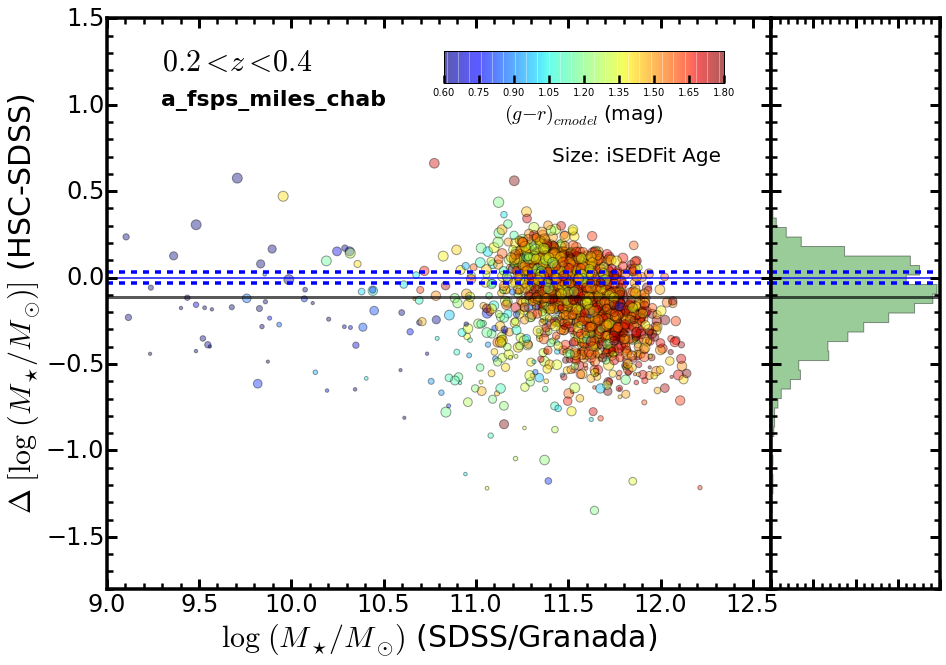

In [17]:
z2Color = z2['gmag_cmodel'] - z2['rmag_cmodel']
z2Age = z2['AGE']
z2MsHSC  = z2['MSTAR']
z2MsHSCErr = z2['MSTAR_ERR']
z2MsSDSS = z2['logms_gran']
z2MsGAMA = z2['logms_gama']

fig = plt.figure(figsize=(13, 9))
#fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = plt.axes(recScat)
ax2 = plt.axes(recHist)

# ---------------------------------------------------------------------------
# Scatter plot

# SDSS v.s. HSC
p = ax1.scatter(z2MsSDSS, (z2MsHSC - z2MsSDSS), 
                c=z2Color, s=z2Age * 10.0, alpha=0.4, 
                label='z2/SDSS', vmin=0.6, vmax=1.8)

# Color bar 
cax = fig.add_axes([0.46, 0.88, 0.3, 0.05]) 
cb = plt.colorbar(p, orientation="horizontal", cax=cax)
cb.ax.set_xlabel(r'$(g-r)_{cmodel}$ (mag)', fontsize=20)

ax1.text(0.67, 0.75, 'Size: iSEDFit Age', fontsize=20, 
         transform = ax1.transAxes)

# Zero line
ax1.axhline(0.0, alpha=0.7, linewidth=2.0)

# Horizontal line 
ax1.axhline(np.nanmean(z2MsHSCErr), linestyle='dashed', linewidth=3.5)
ax1.axhline(-1.0 * np.nanmean(z2MsHSCErr), linestyle='dashed', 
            linewidth=3.5)

ax1.axhline(np.nanmedian((z2MsHSC - z2MsSDSS)), color='k',
            alpha=0.65, linewidth=3.0)

# Axes setup
#  Minor Ticks on 
ax1.minorticks_on()
#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(3.5)
#  Tick Label Size 
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
#  Tick Length and Width
ax1.tick_params('both', length=10, width=3.0, which='major')
ax1.tick_params('both', length=6, width=2.5, which='minor')

# Label
ax1.set_xlabel('$\log\ (M_{\star}/M_{\odot})$ (SDSS/Granada)',  size=30)
ax1.set_ylabel('$\Delta\ [\log\ (M_{\star}/M_{\odot})]$ (HSC-SDSS)', size=30)
# Axis limits
ax1.set_xlim(9.0, 12.6)
ax1.set_ylim(-1.8, 1.5)

ax1.text(9.3, 1.2, '$0.2 < z < 0.4$', fontsize=30)
ax1.text(9.3, 1.0, sed_model, fontsize=22, fontweight='bold')

# ---------------------------------------------------------------------------
# Histogram 
n, bins, patches=ax2.hist((z2MsHSC - z2MsSDSS), bins=60, range=[-1.8, 1.5], 
                             orientation='horizontal', histtype='stepfilled', 
                             color='g', alpha=0.4, normed=1)
#n, bins, patches=ax2.hist((yuse-xuse), bins=50, range=[-1.2, 4.2], 
#                             orientation='horizontal', histtype='step', 
#                             color='k', alpha=0.8, normed=1, linewidth=3.5)

ax2.set_ylim(ax1.get_ylim())

#ax2.legend(fontsize=15)

# Axes setup
#  Minor Ticks on 
ax2.minorticks_on()

#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax2.spines[axis].set_linewidth(3.5)
#  Tick Label Size 
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
#  Tick Length and Width
ax2.tick_params('both', length=10, width=3.0, which='major')
ax2.tick_params('both', length=6, width=2.5, which='minor')


ax2.axhline(0.0, alpha=0.7, linewidth=2.0)

# Horizontal line 
ax2.axhline(np.nanmean(z2MsHSCErr), linestyle='dashed', linewidth=3.5)
ax2.axhline(-1.0 * np.nanmean(z2MsHSCErr), linestyle='dashed', 
            linewidth=3.5)

ax2.axhline(np.nanmedian((z2MsHSC - z2MsSDSS)), color='k',
            alpha=0.65, linewidth=3.0)

ax2.yaxis.set_major_formatter(NullFormatter())
ax2.xaxis.set_major_formatter(NullFormatter())

#fig.savefig('hsc_gama_cmodelmag_i_1.png', dpi=90)

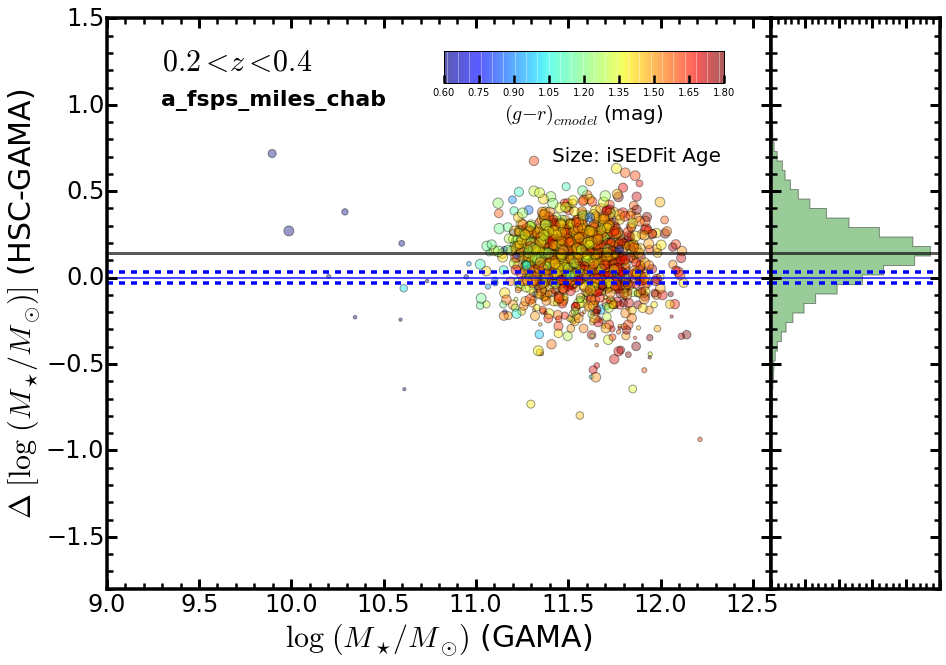

In [18]:
z2Color = z2['gmag_cmodel'] - z2['rmag_cmodel']
z2Age = z2['AGE']
z2MsHSC  = z2['MSTAR']
z2MsHSCErr = z2['MSTAR_ERR']
z2MsSDSS = z2['logms_gran']
z1MsGAMA = z1['logms_gama'] + np.log10(z1['fluxscale_gama'])

fig = plt.figure(figsize=(13, 9))
#fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = plt.axes(recScat)
ax2 = plt.axes(recHist)

# ---------------------------------------------------------------------------
# Scatter plot

# GAMA v.s. HSC
p = ax1.scatter(z2MsSDSS, (z2MsHSC - z2MsGAMA), 
                c=z2Color, s=z2Age * 10.0, alpha=0.4, 
                label='z2/GAMA', vmin=0.6, vmax=1.8)

# Color bar 
cax = fig.add_axes([0.46, 0.88, 0.3, 0.05]) 
cb = plt.colorbar(p, orientation="horizontal", cax=cax)
cb.ax.set_xlabel(r'$(g-r)_{cmodel}$ (mag)', fontsize=20)

ax1.text(0.67, 0.75, 'Size: iSEDFit Age', fontsize=20, 
         transform = ax1.transAxes)

# Zero line
ax1.axhline(0.0, alpha=0.7, linewidth=2.0)

# Horizontal line 
ax1.axhline(np.nanmean(z2MsHSCErr), linestyle='dashed', linewidth=3.5)
ax1.axhline(-1.0 * np.nanmean(z2MsHSCErr), linestyle='dashed', 
            linewidth=3.5)

ax1.axhline(np.nanmedian((z2MsHSC - z2MsGAMA)), color='k',
            alpha=0.65, linewidth=3.0)

# Axes setup
#  Minor Ticks on 
ax1.minorticks_on()
#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(3.5)
#  Tick Label Size 
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
#  Tick Length and Width
ax1.tick_params('both', length=10, width=3.0, which='major')
ax1.tick_params('both', length=6, width=2.5, which='minor')

# Label
ax1.set_xlabel('$\log\ (M_{\star}/M_{\odot})$ (GAMA)',  size=30)
ax1.set_ylabel('$\Delta\ [\log\ (M_{\star}/M_{\odot})]$ (HSC-GAMA)', size=30)
# Axis limits
ax1.set_xlim(9.0, 12.6)
ax1.set_ylim(-1.8, 1.5)

ax1.text(9.3, 1.2, '$0.2 < z < 0.4$', fontsize=30)
ax1.text(9.3, 1.0, sed_model, fontsize=22, fontweight='bold')

# ---------------------------------------------------------------------------
# Histogram 
n, bins, patches=ax2.hist((z2MsHSC - z2MsGAMA), bins=60, range=[-1.8, 1.5], 
                             orientation='horizontal', histtype='stepfilled', 
                             color='g', alpha=0.4, normed=1)
#n, bins, patches=ax2.hist((yuse-xuse), bins=50, range=[-1.2, 4.2], 
#                             orientation='horizontal', histtype='step', 
#                             color='k', alpha=0.8, normed=1, linewidth=3.5)

ax2.set_ylim(ax1.get_ylim())

#ax2.legend(fontsize=15)

# Axes setup
#  Minor Ticks on 
ax2.minorticks_on()

#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax2.spines[axis].set_linewidth(3.5)
#  Tick Label Size 
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
#  Tick Length and Width
ax2.tick_params('both', length=10, width=3.0, which='major')
ax2.tick_params('both', length=6, width=2.5, which='minor')


ax2.axhline(0.0, alpha=0.7, linewidth=2.0)

# Horizontal line 
ax2.axhline(np.nanmean(z2MsHSCErr), linestyle='dashed', linewidth=3.5)
ax2.axhline(-1.0 * np.nanmean(z2MsHSCErr), linestyle='dashed', 
            linewidth=3.5)

ax2.axhline(np.nanmedian((z2MsHSC - z2MsGAMA)), color='k',
            alpha=0.65, linewidth=3.0)

ax2.yaxis.set_major_formatter(NullFormatter())
ax2.xaxis.set_major_formatter(NullFormatter())

#fig.savefig('hsc_gama_cmodelmag_i_1.png', dpi=90)

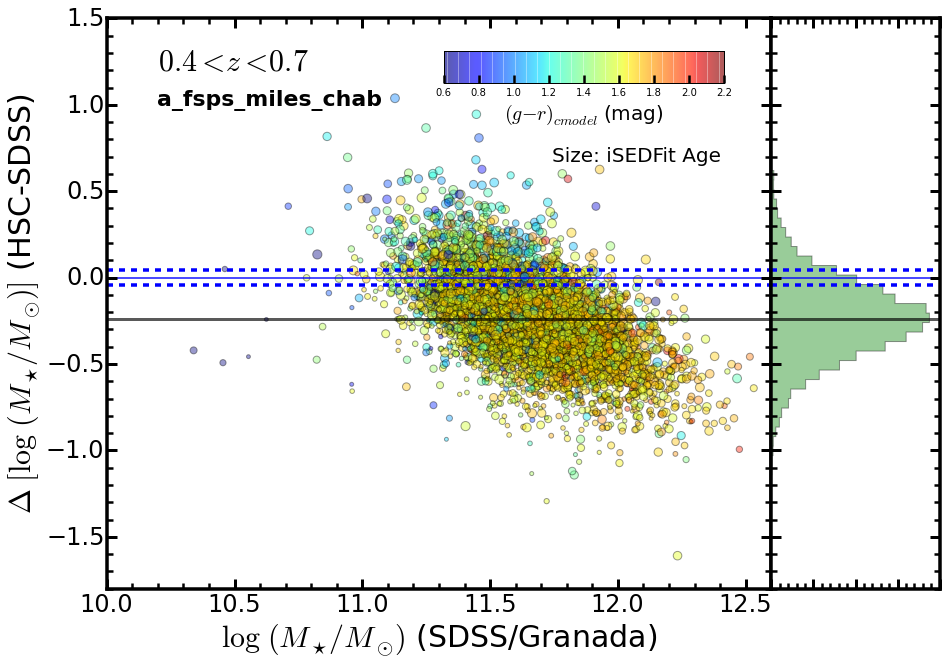

In [19]:
z3Color = z3['gmag_cmodel'] - z3['rmag_cmodel']
z3Age = z3['AGE']
z3MsHSC  = z3['MSTAR']
z3MsHSCErr = z3['MSTAR_ERR']
z3MsSDSS = z3['logms_gran']
z3MsGAMA = z3['logms_gama']

fig = plt.figure(figsize=(13, 9))
#fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = plt.axes(recScat)
ax2 = plt.axes(recHist)

# ---------------------------------------------------------------------------
# Scatter plot

# SDSS v.s. HSC
p = ax1.scatter(z3MsSDSS, (z3MsHSC - z3MsSDSS), 
                c=z3Color, s=z3Age * 10.0, alpha=0.4, 
                label='z2/SDSS', vmin=0.6, vmax=2.2)

# Color bar 
cax = fig.add_axes([0.46, 0.88, 0.3, 0.05]) 
cb = plt.colorbar(p, orientation="horizontal", cax=cax)
cb.ax.set_xlabel(r'$(g-r)_{cmodel}$ (mag)', fontsize=20)

ax1.text(0.67, 0.75, 'Size: iSEDFit Age', fontsize=20, 
         transform = ax1.transAxes)

# Zero line
ax1.axhline(0.0, alpha=0.7, linewidth=2.0)

# Horizontal line 
ax1.axhline(np.nanmean(z3MsHSCErr), linestyle='dashed', linewidth=3.5)
ax1.axhline(-1.0 * np.nanmean(z3MsHSCErr), linestyle='dashed', 
            linewidth=3.5)

ax1.axhline(np.nanmedian((z3MsHSC - z3MsSDSS)), color='k',
            alpha=0.65, linewidth=3.0)

# Axes setup
#  Minor Ticks on 
ax1.minorticks_on()
#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(3.5)
#  Tick Label Size 
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
#  Tick Length and Width
ax1.tick_params('both', length=10, width=3.0, which='major')
ax1.tick_params('both', length=6, width=2.5, which='minor')

# Label
ax1.set_xlabel('$\log\ (M_{\star}/M_{\odot})$ (SDSS/Granada)',  size=30)
ax1.set_ylabel('$\Delta\ [\log\ (M_{\star}/M_{\odot})]$ (HSC-SDSS)', size=30)
# Axis limits
ax1.set_xlim(10.0, 12.6)
ax1.set_ylim(-1.8, 1.5)

ax1.text(10.2, 1.2, '$0.4 < z < 0.7$', fontsize=30)
ax1.text(10.2, 1.0, sed_model, fontsize=22, fontweight='bold')

# ---------------------------------------------------------------------------
# Histogram 
n, bins, patches=ax2.hist((z3MsHSC - z3MsSDSS), bins=60, range=[-1.8, 1.5], 
                             orientation='horizontal', histtype='stepfilled', 
                             color='g', alpha=0.4, normed=1)
#n, bins, patches=ax2.hist((yuse-xuse), bins=50, range=[-1.2, 4.2], 
#                             orientation='horizontal', histtype='step', 
#                             color='k', alpha=0.8, normed=1, linewidth=3.5)

ax2.set_ylim(ax1.get_ylim())

#ax2.legend(fontsize=15)

# Axes setup
#  Minor Ticks on 
ax2.minorticks_on()

#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax2.spines[axis].set_linewidth(3.5)
#  Tick Label Size 
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
#  Tick Length and Width
ax2.tick_params('both', length=10, width=3.0, which='major')
ax2.tick_params('both', length=6, width=2.5, which='minor')


ax2.axhline(0.0, alpha=0.7, linewidth=2.0)

# Horizontal line 
ax2.axhline(np.nanmean(z3MsHSCErr), linestyle='dashed', linewidth=3.5)
ax2.axhline(-1.0 * np.nanmean(z3MsHSCErr), linestyle='dashed', 
            linewidth=3.5)

ax2.axhline(np.nanmedian((z3MsHSC - z3MsSDSS)), color='k',
            alpha=0.65, linewidth=3.0)

ax2.yaxis.set_major_formatter(NullFormatter())
ax2.xaxis.set_major_formatter(NullFormatter())

#fig.savefig('hsc_gama_cmodelmag_i_1.png', dpi=90)

# HSC Stellar Mass Histogram

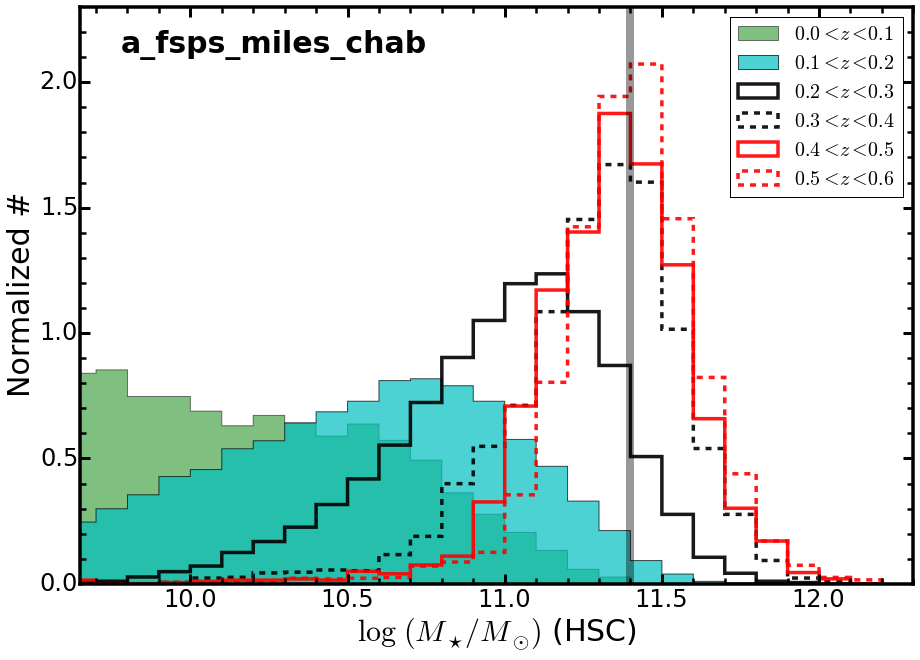

In [66]:
z1a = z1[(z1['z_use'] <= 0.10)]
z1b = z1[(z1['z_use'] > 0.10) & (z1['z_use'] <= 0.20)]
z2a = z2[(z2['z_use'] > 0.20) & (z2['z_use'] <= 0.30)]
z2b = z2[(z2['z_use'] > 0.30) & (z2['z_use'] <= 0.40)]
z3a = z3[(z3['z_use'] > 0.40) & (z3['z_use'] <= 0.50)]
z3b = z3[(z3['z_use'] > 0.50) & (z3['z_use'] <= 0.60)]
z3c = z3[(z3['z_use'] > 0.60) & (z3['z_use'] <= 0.70)]

fig = plt.figure(figsize=(13, 9))
#fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
rec = [0.10, 0.10, 0.89, 0.89]
ax1 = plt.axes(rec)

ax1.axvline(11.4, linewidth=8.0, color='k', alpha=0.4)

# ---------------------------------------------------------------------------
# Histogram 
n1n, bins1, patches1=ax1.hist(z1a['MSTAR'], bins=27, range=[9.5, 12.2], 
                              orientation='vertical', histtype='stepfilled', 
                              color='g', alpha=0.5, normed=1, label='$0.0<z<0.1$')

n2n, bins2, patches2=ax1.hist(z1b['MSTAR'], bins=27, range=[9.5, 12.2], 
                              orientation='vertical', histtype='stepfilled', 
                              color='c', alpha=0.7, normed=1, label='$0.1<z<0.2$')

n3n, bins3, patches3=ax1.hist(z2a['MSTAR'], bins=27, range=[9.5, 12.2], 
                              orientation='vertical', histtype='step', 
                              color='k', alpha=0.9, normed=1, label='$0.2<z<0.3$',
                              linewidth=3.5)

n4n, bins4, patches4=ax1.hist(z2b['MSTAR'], bins=27, range=[9.5, 12.2], 
                              orientation='vertical', histtype='step', 
                              color='k', alpha=0.9, normed=1, label='$0.3<z<0.4$',
                              linestyle='dashed', linewidth=3.5)

n5n, bins5, patches5=ax1.hist(z3a['MSTAR'], bins=27, range=[9.5, 12.2], 
                              orientation='vertical', histtype='step', 
                              color='r', alpha=0.9, normed=1, label='$0.4<z<0.5$',
                              linewidth=3.5)

n6n, bins6, patches6=ax1.hist(z3b['MSTAR'], bins=27, range=[9.5, 12.2], 
                              orientation='vertical', histtype='step', 
                              color='r', alpha=0.9, normed=1, label='$0.5<z<0.6$',
                              linestyle='dashed', linewidth=3.5)

ax1.legend(fontsize=20)

ax1.set_xlim(9.65, 12.30)
ax1.set_ylim(0.001, 2.30)

# Axes setup
#  Minor Ticks on 
ax1.minorticks_on()

#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(3.5)
#  Tick Label Size 
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
#  Tick Length and Width
ax1.tick_params('both', length=10, width=3.0, which='major')
ax1.tick_params('both', length=6, width=2.5, which='minor')

ax1.axhline(0.0, alpha=0.7, linewidth=2.0)

# Label
ax1.set_xlabel('$\log\ (M_{\star}/M_{\odot})$ (HSC)',  size=30)
ax1.set_ylabel('Normalized #', size=30)

ax1.text(0.05, 0.92, sed_model, fontsize=30, fontweight='bold', 
         transform=ax1.transAxes)

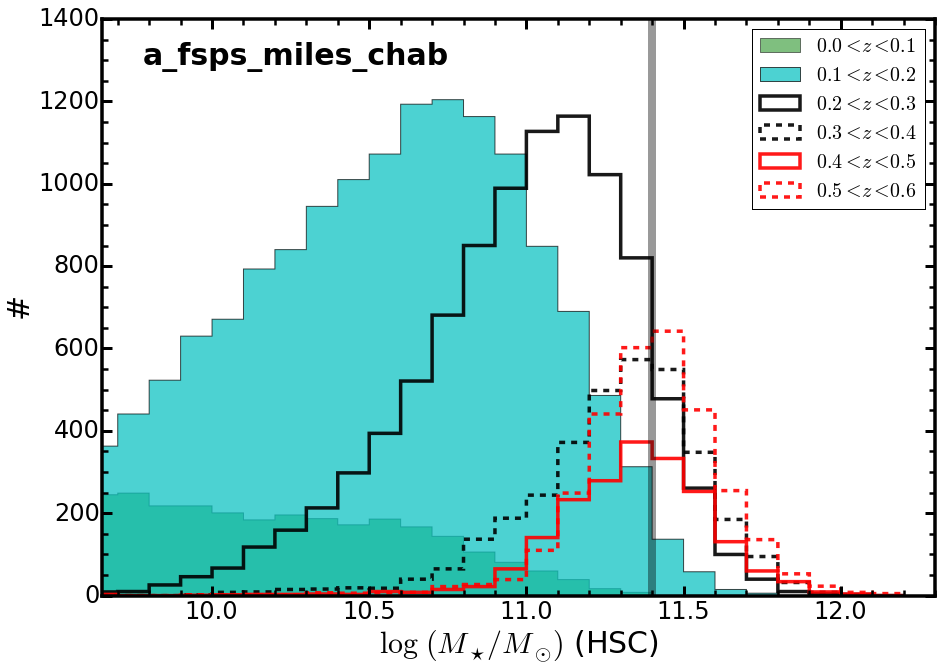

In [108]:
fig = plt.figure(figsize=(13, 9))
#fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
rec = [0.10, 0.10, 0.89, 0.89]
ax1 = plt.axes(rec)

ax1.axvline(11.4, linewidth=8.0, color='k', alpha=0.4)

# ---------------------------------------------------------------------------
# Histogram 
n1, bins1, patches1=ax1.hist(z1a['MSTAR'], bins=27, range=[9.5, 12.2], 
                             orientation='vertical', histtype='stepfilled', 
                             color='g', alpha=0.5, normed=0, label='$0.0<z<0.1$')

n2, bins2, patches2=ax1.hist(z1b['MSTAR'], bins=27, range=[9.5, 12.2], 
                             orientation='vertical', histtype='stepfilled', 
                             color='c', alpha=0.7, normed=0, label='$0.1<z<0.2$')

n3, bins3, patches3=ax1.hist(z2a['MSTAR'], bins=27, range=[9.5, 12.2], 
                             orientation='vertical', histtype='step', 
                             color='k', alpha=0.9, normed=0, label='$0.2<z<0.3$',
                             linewidth=3.5)

n4, bins4, patches4=ax1.hist(z2b['MSTAR'], bins=27, range=[9.5, 12.2], 
                             orientation='vertical', histtype='step', 
                             color='k', alpha=0.9, normed=0, label='$0.3<z<0.4$',
                             linestyle='dashed', linewidth=3.5)

n5, bins5, patches5=ax1.hist(z3a['MSTAR'], bins=27, range=[9.5, 12.2], 
                             orientation='vertical', histtype='step', 
                             color='r', alpha=0.9, normed=0, label='$0.4<z<0.5$',
                             linewidth=3.5)

n6, bins6, patches6=ax1.hist(z3b['MSTAR'], bins=27, range=[9.5, 12.2], 
                             orientation='vertical', histtype='step', 
                             color='r', alpha=0.9, normed=0, label='$0.5<z<0.6$',
                             linestyle='dashed', linewidth=3.5)

ax1.legend(fontsize=20)

ax1.set_xlim(9.65, 12.30)

# Axes setup
#  Minor Ticks on 
ax1.minorticks_on()

#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(3.5)
#  Tick Label Size 
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
#  Tick Length and Width
ax1.tick_params('both', length=10, width=3.0, which='major')
ax1.tick_params('both', length=6, width=2.5, which='minor')

ax1.axhline(0.0, alpha=0.7, linewidth=2.0)

# Label
ax1.set_xlabel('$\log\ (M_{\star}/M_{\odot})$ (HSC)',  size=30)
ax1.set_ylabel('#', size=30)

ax1.text(0.05, 0.92, sed_model, fontsize=30, fontweight='bold', 
         transform=ax1.transAxes)

## Histogram of Number Density

In [90]:
import cosmology
c=cosmology.Cosmo(H0=70.0, omega_m=0.3, omega_l=0.7, flat=1)

In [91]:
binSize = 0.1
area = 54.0

In [92]:
d1 = (c.V(np.nanmin(z1a['z_use']), np.nanmax(z1a['z_use'])) / ((360.0 ** 2.0) / np.pi)) * area
d2 = (c.V(np.nanmin(z1b['z_use']), np.nanmax(z1b['z_use'])) / ((360.0 ** 2.0) / np.pi)) * area
d3 = (c.V(np.nanmin(z2a['z_use']), np.nanmax(z2a['z_use'])) / ((360.0 ** 2.0) / np.pi)) * area
d4 = (c.V(np.nanmin(z2b['z_use']), np.nanmax(z2b['z_use'])) / ((360.0 ** 2.0) / np.pi)) * area
d5 = (c.V(np.nanmin(z3a['z_use']), np.nanmax(z3a['z_use'])) / ((360.0 ** 2.0) / np.pi)) * area
d6 = (c.V(np.nanmin(z3b['z_use']), np.nanmax(z3b['z_use'])) / ((360.0 ** 2.0) / np.pi)) * area

In [101]:
print(d1, d2, d3, d4, d5, d6)

401529.537603 2584807.22556 6354314.08676 11115862.3631 16447651.427 21949200.0003


In [93]:
dn1 = np.log10(n1 / (d1 * binSize))
dn2 = np.log10(n2 / (d2 * binSize))
dn3 = np.log10(n3 / (d3 * binSize))
dn4 = np.log10(n4 / (d4 * binSize))
dn5 = np.log10(n5 / (d5 * binSize))
dn6 = np.log10(n6 / (d6 * binSize))

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log10


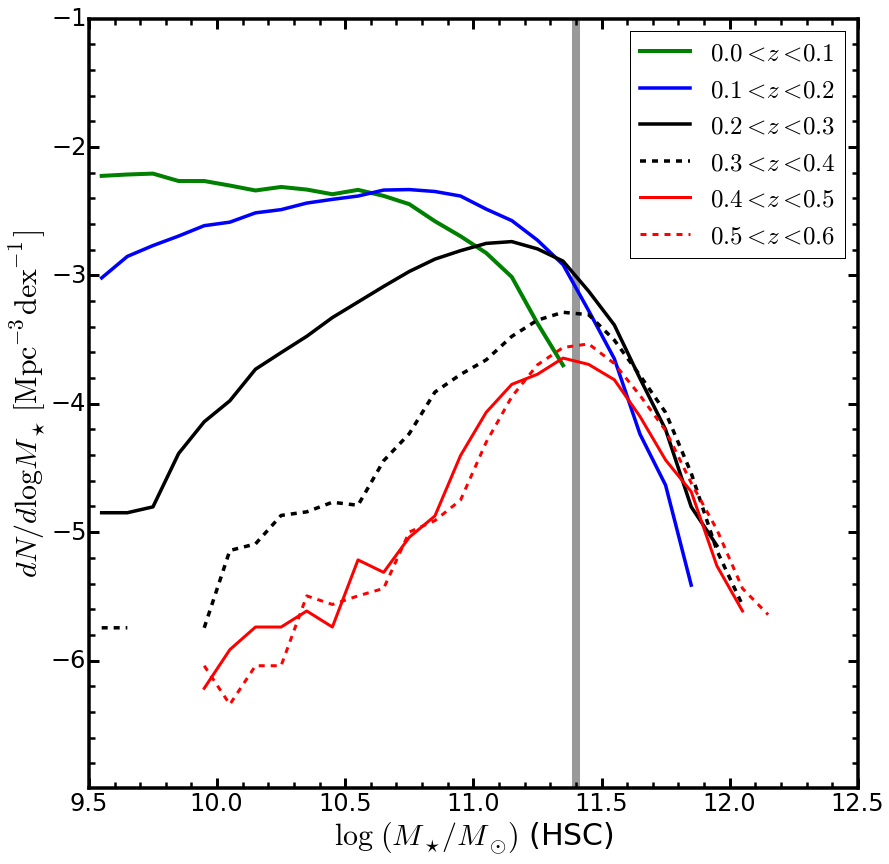

In [98]:
fig = plt.figure(figsize=(12, 12))
rec = [0.10, 0.10, 0.89, 0.89]
ax1 = plt.axes(rec)

ax1.axvline(11.4, color='k', linewidth=8.0, alpha=0.4)

ax1.plot((bins1[1:] + bins1[0:-1])/2.0, dn1, c='g', 
         linewidth=4.0, label='$0.0 < z < 0.1$')
ax1.plot((bins2[1:] + bins2[0:-1])/2.0, dn2, c='b', 
         linewidth=3.5, label='$0.1 < z < 0.2$')
ax1.plot((bins3[1:] + bins3[0:-1])/2.0, dn3, c='k', 
         linewidth=3.5, label='$0.2 < z < 0.3$')
ax1.plot((bins4[1:] + bins4[0:-1])/2.0, dn4, c='k', 
         linewidth=3.5, linestyle='dashed', label='$0.3 < z < 0.4$')
ax1.plot((bins5[1:] + bins5[0:-1])/2.0, dn5, c='r', 
         linewidth=3.0, label='$0.4 < z < 0.5$')
ax1.plot((bins6[1:] + bins6[0:-1])/2.0, dn6, c='r', 
         linewidth=3.0, linestyle='dashed', label='$0.5 < z < 0.6$')

ax1.legend(fontsize=25)

# Axes setup
#  Minor Ticks on 
ax1.minorticks_on()

#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(3.5)
#  Tick Label Size 
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
#  Tick Length and Width
ax1.tick_params('both', length=10, width=3.0, which='major')
ax1.tick_params('both', length=6, width=2.5, which='minor')

ax1.axhline(0.0, alpha=0.7, linewidth=2.0)

ax1.set_ylim(-6.99, -1.001)

# Label
ax1.set_xlabel('$\log\ (M_{\star}/M_{\odot})$ (HSC)',  size=30)
ax1.set_ylabel('$dN/d\logM_{\star}\ [{\mathrm{Mpc}^{-3}}{\mathrm{dex}^{-1}}]$', size=30)

# Compare with redMapper matched cluster

In [102]:
red = fits.open('redmapper/hsc_redmapper_cluster_gama_hscmass_1509.fits')[1].data
red1 = red[red['Z_LAMBDA'] <= 0.1]
red2 = red[(red['Z_LAMBDA'] > 0.1) & (red['Z_LAMBDA'] <= 0.2)]
red3 = red[(red['Z_LAMBDA'] > 0.2) & (red['Z_LAMBDA'] <= 0.3)]
red4 = red[(red['Z_LAMBDA'] > 0.3) & (red['Z_LAMBDA'] <= 0.4)]
red5 = red[(red['Z_LAMBDA'] > 0.4) & (red['Z_LAMBDA'] <= 0.5)]

In [115]:
len(red)

159

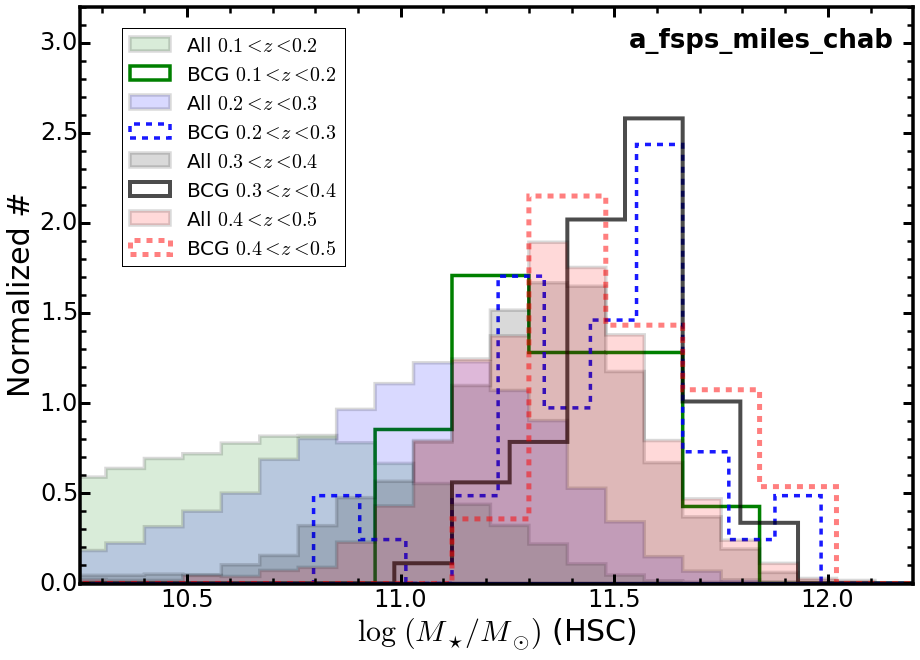

In [107]:
fig = plt.figure(figsize=(13, 9))
rec = [0.10, 0.10, 0.89, 0.89]
ax1 = plt.axes(rec)

# ---------------------------------------------------------------------------
# Histogram 
n1, bins1, patches1=ax1.hist(z1b['MSTAR'], bins=30, range=[9.5, 12.2], 
                             orientation='vertical', histtype='stepfilled', 
                             color='g', alpha=0.15, normed=1, label='All $0.1<z<0.2$',
                             linewidth=3.5)
n1, bins1, patches1=ax1.hist(red2['MSTAR'], bins=15, range=[9.5, 12.2], 
                             orientation='vertical', histtype='step', 
                             color='g', alpha=1.0, normed=1, label='BCG $0.1<z<0.2$',
                             linewidth=3.5, linestyle='solid')

n3, bins3, patches3=ax1.hist(z2a['MSTAR'], bins=30, range=[9.5, 12.2], 
                             orientation='vertical', histtype='stepfilled', 
                             color='b', alpha=0.15, normed=1, label='All $0.2<z<0.3$',
                             linewidth=3.5)
n1, bins1, patches1=ax1.hist(red3['MSTAR'], bins=25, range=[9.5, 12.2], 
                             orientation='vertical', histtype='step', 
                             color='b', alpha=0.9, normed=1, label='BCG $0.2<z<0.3$',
                             linewidth=3.5, linestyle='dashed')

n4, bins4, patches4=ax1.hist(z2b['MSTAR'], bins=30, range=[9.5, 12.2], 
                             orientation='vertical', histtype='stepfilled', 
                             color='k', alpha=0.15, normed=1, label='All $0.3<z<0.4$',
                             linewidth=3.5)
n1, bins1, patches1=ax1.hist(red4['MSTAR'], bins=20, range=[9.5, 12.2], 
                             orientation='vertical', histtype='step', 
                             color='k', alpha=0.7, normed=1, label='BCG $0.3<z<0.4$',
                             linewidth=4.0, linestyle='solid')

n5, bins5, patches5=ax1.hist(z3a['MSTAR'], bins=30, range=[9.5, 12.2], 
                             orientation='vertical', histtype='stepfilled', 
                             color='r', alpha=0.15, normed=1, label='All $0.4<z<0.5$',
                             linewidth=3.5)
n1, bins1, patches1=ax1.hist(red5['MSTAR'], bins=15, range=[9.5, 12.2], 
                             orientation='vertical', histtype='step', 
                             color='r', alpha=0.5, normed=1, label='BCG $0.4<z<0.5$',
                             linewidth=5.0, linestyle='dashed')

ax1.legend(fontsize=20, loc=(0.05, 0.55))

ax1.set_xlim(10.25, 12.2)
ax1.set_ylim(-0.001, 3.2)

# Axes setup
#  Minor Ticks on 
ax1.minorticks_on()

#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(3.5)
#  Tick Label Size 
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
#  Tick Length and Width
ax1.tick_params('both', length=10, width=3.0, which='major')
ax1.tick_params('both', length=6, width=2.5, which='minor')

ax1.axhline(0.0, alpha=0.7, linewidth=2.0)

# Label
ax1.set_xlabel('$\log\ (M_{\star}/M_{\odot})$ (HSC)',  size=30)
ax1.set_ylabel('Normalized #', size=30)

ax1.text(0.66, 0.93, sed_model, fontsize=26, fontweight='bold', 
         transform=ax1.transAxes)

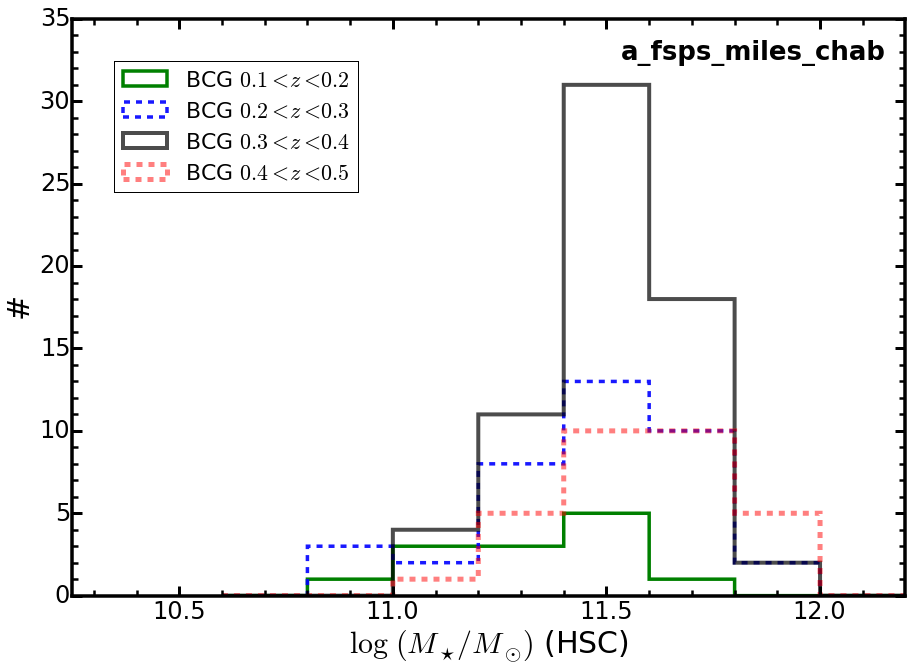

In [111]:
fig = plt.figure(figsize=(13, 9))
rec = [0.10, 0.10, 0.89, 0.89]
ax1 = plt.axes(rec)

# ---------------------------------------------------------------------------
# Histogram 
r2, rb2, patches2=ax1.hist(red2['MSTAR'], bins=9, range=[10.6, 12.4], 
                             orientation='vertical', histtype='step', 
                             color='g', alpha=1.0, normed=0, label='BCG $0.1<z<0.2$',
                             linewidth=3.5, linestyle='solid')

r3, rb3, patches3=ax1.hist(red3['MSTAR'], bins=9, range=[10.6, 12.4], 
                             orientation='vertical', histtype='step', 
                             color='b', alpha=0.9, normed=0, label='BCG $0.2<z<0.3$',
                             linewidth=3.5, linestyle='dashed')

r4, rb4, patches4=ax1.hist(red4['MSTAR'], bins=9, range=[10.6, 12.4], 
                             orientation='vertical', histtype='step', 
                             color='k', alpha=0.7, normed=0, label='BCG $0.3<z<0.4$',
                             linewidth=4.0, linestyle='solid')

r5, rb5, patches5=ax1.hist(red5['MSTAR'], bins=9, range=[10.6, 12.4], 
                             orientation='vertical', histtype='step', 
                             color='r', alpha=0.5, normed=0, label='BCG $0.4<z<0.5$',
                             linewidth=5.0, linestyle='dashed')

ax1.legend(fontsize=22, loc=(0.05, 0.70))

ax1.set_xlim(10.25, 12.2)
#ax1.set_ylim(-0.001, 3.2)

# Axes setup
#  Minor Ticks on 
ax1.minorticks_on()

#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(3.5)
#  Tick Label Size 
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
#  Tick Length and Width
ax1.tick_params('both', length=10, width=3.0, which='major')
ax1.tick_params('both', length=6, width=2.5, which='minor')

ax1.axhline(0.0, alpha=0.7, linewidth=2.0)

# Label
ax1.set_xlabel('$\log\ (M_{\star}/M_{\odot})$ (HSC)',  size=30)
ax1.set_ylabel('#', size=30)

ax1.text(0.66, 0.93, sed_model, fontsize=26, fontweight='bold', 
         transform=ax1.transAxes)

In [112]:
dr2 = np.log10(r2 / (d2 * binSize))
dr3 = np.log10(r3 / (d3 * binSize))
dr4 = np.log10(r4 / (d4 * binSize))
dr5 = np.log10(r5 / (d5 * binSize))

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log10


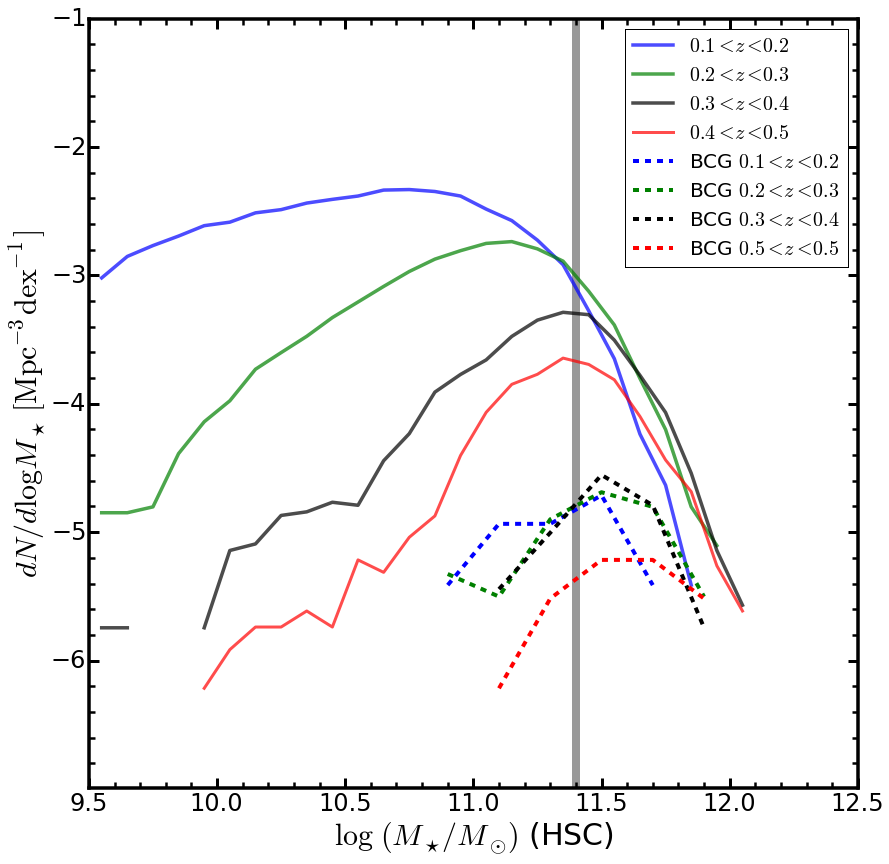

In [114]:
fig = plt.figure(figsize=(12, 12))
rec = [0.10, 0.10, 0.89, 0.89]
ax1 = plt.axes(rec)

ax1.axvline(11.4, color='k', linewidth=8.0, alpha=0.4)

#ax1.plot((bins1[1:] + bins1[0:-1])/2.0, dn1, c='g', 
#         linewidth=4.0, label='$0.0 < z < 0.1$')
ax1.plot((bins2[1:] + bins2[0:-1])/2.0, dn2, c='b', 
         linewidth=3.5, label='$0.1 < z < 0.2$', alpha=0.7)
ax1.plot((bins3[1:] + bins3[0:-1])/2.0, dn3, c='g', 
         linewidth=3.5, label='$0.2 < z < 0.3$', alpha=0.7)
ax1.plot((bins4[1:] + bins4[0:-1])/2.0, dn4, c='k', 
         linewidth=3.5, label='$0.3 < z < 0.4$', alpha=0.7)
ax1.plot((bins5[1:] + bins5[0:-1])/2.0, dn5, c='r', 
         linewidth=3.0, label='$0.4 < z < 0.5$', alpha=0.7)
#ax1.plot((bins6[1:] + bins6[0:-1])/2.0, dn6, c='r', 
#         linewidth=3.0, linestyle='dashed', label='$0.5 < z < 0.6$')

ax1.plot((rb2[1:] + rb2[0:-1])/2.0, dr2, c='b', 
         linewidth=4.0, label='BCG $0.1 < z < 0.2$', 
         linestyle='dashed')
ax1.plot((rb3[1:] + rb3[0:-1])/2.0, dr3, c='g', 
         linewidth=4.0, label='BCG $0.2 < z < 0.3$', 
         linestyle='dashed')
ax1.plot((rb4[1:] + rb4[0:-1])/2.0, dr4, c='k', 
         linewidth=4.0, label='BCG $0.3 < z < 0.4$', 
         linestyle='dashed')
ax1.plot((rb5[1:] + rb5[0:-1])/2.0, dr5, c='r', 
         linewidth=4.0, label='BCG $0.5 < z < 0.5$', 
         linestyle='dashed')

ax1.legend(fontsize=20)

# Axes setup
#  Minor Ticks on 
ax1.minorticks_on()

#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(3.5)
#  Tick Label Size 
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
#  Tick Length and Width
ax1.tick_params('both', length=10, width=3.0, which='major')
ax1.tick_params('both', length=6, width=2.5, which='minor')

ax1.axhline(0.0, alpha=0.7, linewidth=2.0)

ax1.set_ylim(-6.99, -1.001)

# Label
ax1.set_xlabel('$\log\ (M_{\star}/M_{\odot})$ (HSC)',  size=30)
ax1.set_ylabel('$dN/d\logM_{\star}\ [{\mathrm{Mpc}^{-3}}{\mathrm{dex}^{-1}}]$', size=30)